In [1]:
# import os
# import numpy as np
# import pandas as pd
# from pathlib import Path
# from sklearn.model_selection import train_test_split
# from sklearn.feature_selection import SelectKBest, mutual_info_classif
# from sklearn.metrics import (
#     precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
# )
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# import matplotlib.pyplot as plt
# import joblib

# # ===================== CONFIG =========================
# INPUT_CSV  = r"C:\Users\gtvca\Downloads\raw-data-kaggle (3).csv"
# OUTPUT_DIR = r"C:\Users\gtvca\Downloads\output_modelo_2"
# DELIMITER  = ";"  # Se o seu CSV for separado por ;
# TEST_SIZE  = 0.20
# RANDOM_SEED = 42
# K_FEATURES = 12    # Máximo de features após seleção
# # =====================================================

# os.makedirs(OUTPUT_DIR, exist_ok=True)

# def riegel_t2(t1_hours, d1_km, d2_km=42.195, exponent=1.06):
#     """Tempo previsto t2 pela fórmula de Riegel: t2 = t1 * (d2/d1)^exponent."""
#     if pd.isna(t1_hours) or pd.isna(d1_km) or d1_km <= 0 or t1_hours <= 0:
#         return np.nan
#     return t1_hours * ((d2_km / d1_km) ** exponent)

# # =========================================
# # 0. Leitura dos Dados
# # =========================================
# df = pd.read_csv(INPUT_CSV, delimiter=DELIMITER)
# df.columns = [c.strip().lower() for c in df.columns]
# df = df.rename(columns={
#     "distance (m)": "distance_m",
#     "elapsed time (s)": "elapsed_s",
#     "elevation gain (m)": "elev_m",
#     "average heart rate (bpm)": "hr_bpm"
# })
# df["timestamp"] = pd.to_datetime(df["timestamp"], dayfirst=True, errors="coerce")
# df.dropna(subset=["timestamp"], inplace=True)

In [2]:
# df.head()

NameError: name 'df' is not defined

In [27]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import joblib
import pickle

In [ ]:
# ===================== CONFIG =========================
INPUT_CSV  = r"C:\Users\gtvca\Downloads\raw-data-kaggle (3).csv"
OUTPUT_DIR = r"C:\Users\gtvca\Downloads\output_modelo_2"
DELIMITER  = ";"  # Se o seu CSV for separado por ;
TEST_SIZE  = 0.20
RANDOM_SEED = 42
K_FEATURES = 12    # Máximo de features após seleção
# =====================================================

os.makedirs(OUTPUT_DIR, exist_ok=True)

def riegel_t2(t1_hours, d1_km, d2_km=42.195, exponent=1.06):
    """Tempo previsto t2 pela fórmula de Riegel: t2 = t1 * (d2/d1)^exponent."""
    if pd.isna(t1_hours) or pd.isna(d1_km) or d1_km <= 0 or t1_hours <= 0:
        return np.nan
    return t1_hours * ((d2_km / d1_km) ** exponent)

In [13]:
# =========================================
# 0. Leitura dos Dados
# =========================================
df = pd.read_csv(INPUT_CSV, delimiter=DELIMITER)
df.columns = [c.strip().lower() for c in df.columns]
df = df.rename(columns={
    "distance (m)": "distance_m",
    "elapsed time (s)": "elapsed_s",
    "elevation gain (m)": "elev_m",
    "average heart rate (bpm)": "hr_bpm"
})
df["timestamp"] = pd.to_datetime(df["timestamp"], dayfirst=True, errors="coerce")
df.dropna(subset=["timestamp"], inplace=True)


In [14]:

# =========================================
# 1. Processamento dos Dados
# =========================================
df["dist_km"] = df["distance_m"] / 1000.0
df["dur_h"]   = df["elapsed_s"] / 3600.0
df["pace_min_km"] = (df["elapsed_s"] / 60.0) / df["dist_km"].replace(0, np.nan)
df["speed_kmh"]   = df["dist_km"] / df["dur_h"].replace(0, np.nan)

# 1.1) Agregação por atleta (sem leakage)

agg = df.groupby("athlete").agg(
    gender=("gender","first"),
    n_runs=("dist_km","count"),
    total_km=("dist_km","sum"),
    avg_km=("dist_km","mean"),
    std_km=("dist_km","std"),
    max_km=("dist_km","max"),
    med_pace_min_km=("pace_min_km","median"),
    avg_pace_min_km=("pace_min_km","mean"),
    std_pace_min_km=("pace_min_km","std"),
    avg_speed_kmh=("speed_kmh","mean"),
    std_speed_kmh=("speed_kmh","std"),
    avg_hr=("hr_bpm","mean"),
    std_hr=("hr_bpm","std"),
    elev_gain_total=("elev_m","sum"),
    elev_gain_avg=("elev_m","mean"),
    elev_gain_std=("elev_m","std"),
    first_ts=("timestamp","min"),
    last_ts=("timestamp","max")
).reset_index()

weeks = ((agg["last_ts"] - agg["first_ts"]).dt.days.clip(lower=1)) / 7.0
agg["weekly_km"] = agg["total_km"] / weeks.replace({0: np.nan})

# Melhor 10k e Riegel
runs_10k = df[(df["dist_km"] >= 9.5) & (df["dist_km"] <= 10.5)].copy()
best10 = (runs_10k.assign(t_hours=runs_10k["elapsed_s"] / 3600.0)
                    .sort_values(["athlete", "t_hours"])
                    .drop_duplicates("athlete"))[["athlete", "dist_km", "elapsed_s"]]
agg = agg.merge(best10.rename(columns={"dist_km": "best10_dist_km", "elapsed_s": "best10_s"}),
                on="athlete", how="left")
agg["best10_h"] = agg["best10_s"] / 3600.0
agg["pred_marathon_h"] = [riegel_t2(t, d) for t, d in zip(agg["best10_h"], agg["best10_dist_km"].fillna(10.0))]

In [15]:
# =========================================
# 2. Separando Dados de Treino e Teste
# =========================================
# Target PROXY: Boston (M=3h30 / F=4h00)
gender_upper = agg["gender"].astype(str).str.upper().str[0]
thr_hours = np.where(gender_upper == "M", 3.5, 4.0)
agg["y_proxy"] = (agg["pred_marathon_h"] <= thr_hours).astype(int)

agg["gender_M"] = (gender_upper == "M").astype(int)
features_all = [
    "gender_M", "n_runs", "total_km", "avg_km", "std_km", "max_km",
    "med_pace_min_km", "avg_pace_min_km", "std_pace_min_km",
    "avg_speed_kmh", "std_speed_kmh",
    "avg_hr", "std_hr",
    "elev_gain_total", "elev_gain_avg", "elev_gain_std",
    "weekly_km"
]

# 2.1) Divisão de treino e teste
X = agg[features_all].fillna(0.0)
y = agg["y_proxy"].astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y)

# 2.2) Seleção de Variáveis
sel = SelectKBest(score_func=mutual_info_classif, k=min(K_FEATURES, X_tr.shape[1]))
sel.fit(X_tr, y_tr)
selected_mask = sel.get_support()
selected_features = [c for c, keep in zip(X.columns, selected_mask) if keep]

In [16]:
selected_features

['n_runs',
 'total_km',
 'avg_km',
 'std_km',
 'med_pace_min_km',
 'std_pace_min_km',
 'avg_speed_kmh',
 'std_speed_kmh',
 'elev_gain_total',
 'elev_gain_avg',
 'elev_gain_std',
 'weekly_km']

In [17]:

# =========================================
# 3. Treinamento dos Modelos com as variáveis selecionadas
# =========================================
# Random Forest
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1, )
rf.fit(X_tr[selected_features], y_tr)
rf_pred = rf.predict(X_te[selected_features])
rf_proba = rf.predict_proba(X_te[selected_features])[:, 1]

# SVM (Support Vector Machine)
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_tr[selected_features], y_tr)
svm_pred = svm.predict(X_te[selected_features])
svm_proba = svm.predict_proba(X_te[selected_features])[:, 1]

In [19]:

# =========================================
# 4.1 Importância de Variáveis
# =========================================
# Random Forest: Mostrando as 10 variáveis mais importantes
rf_importances = pd.DataFrame({
    'feature': selected_features,
    'importance': rf.feature_importances_
})
rf_importances = rf_importances.sort_values(by='importance', ascending=False)
print("Importância das variáveis - RandomForest:")
print(rf_importances.head(10))

Importância das variáveis - RandomForest:
            feature  importance
1          total_km    0.173561
0            n_runs    0.149644
8   elev_gain_total    0.142288
7     std_speed_kmh    0.077770
2            avg_km    0.073810
11        weekly_km    0.066825
10    elev_gain_std    0.064294
6     avg_speed_kmh    0.062657
5   std_pace_min_km    0.056020
4   med_pace_min_km    0.055185


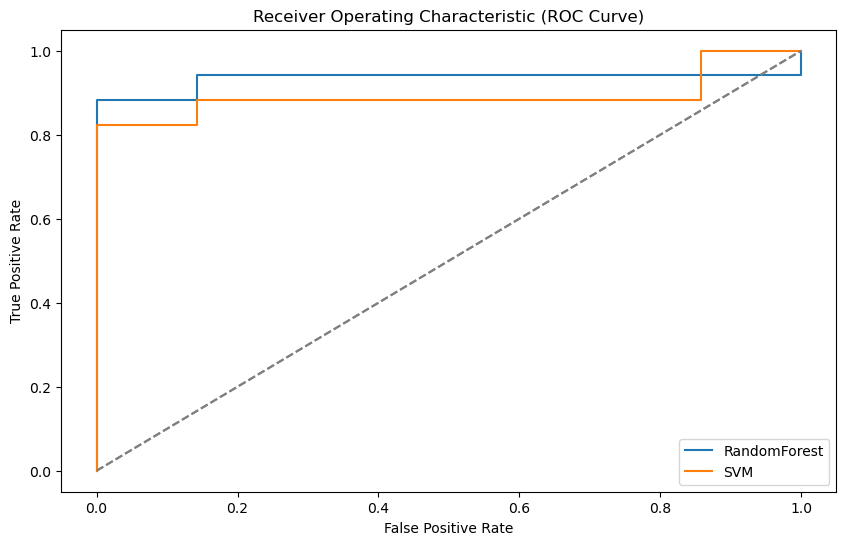

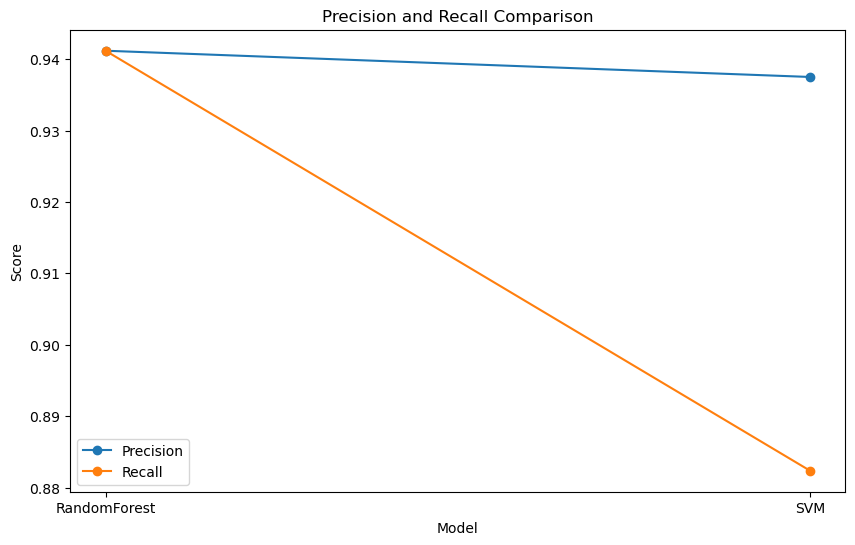

In [29]:

# =========================================
# 5. Avaliando Resultados do Modelo
# =========================================

# 5.1) Matriz de Confusão (Precision, Recall, F1-Score)
def metrics_dict(y_true, y_pred, y_proba):
    return {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred),
        "accuracy": accuracy_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "tn_fp_fn_tp": confusion_matrix(y_true, y_pred).ravel().tolist()
    }

rf_metrics = metrics_dict(y_te, rf_pred, rf_proba)
svm_metrics = metrics_dict(y_te, svm_pred, svm_proba)

df_metrics = pd.DataFrame([
    {"model": "RandomForest", **rf_metrics},
    {"model": "SVM", **svm_metrics}
])
# =========================================
# 5.2 AUC ao Longo do Tempo (Curva ROC) - com salvamento
# =========================================
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC Curve)')

fpr_rf, tpr_rf, _ = roc_curve(y_te, rf_proba)
fpr_svm, tpr_svm, _ = roc_curve(y_te, svm_proba)

plt.figure(figsize=(10, 6))
plot_roc_curve(fpr_rf, tpr_rf, label="RandomForest")
plot_roc_curve(fpr_svm, tpr_svm, label="SVM")
plt.legend(loc="lower right")

# Salvar imagem da ROC
roc_path = Path(OUTPUT_DIR, "roc_curve.png")
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
plt.show()

# =========================================
# 5.3 Precision e Recall ao Longo do Tempo - com salvamento
# =========================================
plt.figure(figsize=(10, 6))
plt.plot(df_metrics["model"], df_metrics["precision"], marker='o', label="Precision")
plt.plot(df_metrics["model"], df_metrics["recall"], marker='o', label="Recall")
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision and Recall Comparison")
plt.legend()

# Salvar imagem Precision/Recall
pr_path = Path(OUTPUT_DIR, "precision_recall.png")
plt.savefig(pr_path, dpi=300, bbox_inches='tight')
plt.show()



In [31]:
rf

RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)

In [35]:

# =========================================
# 5.4 Teste e Avaliação dos Resultados
# =========================================
# Salvar os modelos treinados
# joblib.dump({"model": rf, "features": selected_features}, Path(OUTPUT_DIR, "model_rf.pkl"))
pickle.dump(rf, open(Path(OUTPUT_DIR, "model_rf.pkl"), 'wb'))
# joblib.dump({"model": svm, "features": selected_features}, Path(OUTPUT_DIR, "model_svm.pkl"))

# Salvar as métricas
df_metrics.to_csv(Path(OUTPUT_DIR, "metrics_comparison_rf_svm.csv"), index=False, encoding="utf-8")

# Matrizes de Confusão
pd.DataFrame([
    {"model": "RandomForest", "tn": rf_metrics["tn_fp_fn_tp"][0], "fp": rf_metrics["tn_fp_fn_tp"][1],
     "fn": rf_metrics["tn_fp_fn_tp"][2], "tp": rf_metrics["tn_fp_fn_tp"][3]},
    {"model": "SVM", "tn": svm_metrics["tn_fp_fn_tp"][0], "fp": svm_metrics["tn_fp_fn_tp"][1],
     "fn": svm_metrics["tn_fp_fn_tp"][2], "tp": svm_metrics["tn_fp_fn_tp"][3]},
]).to_csv(Path(OUTPUT_DIR, "confusion_matrices_rf_svm.csv"), index=False, encoding="utf-8")

print(f"Arquivos salvos em: {OUTPUT_DIR}")

# Quantidade de atletas aptos e não aptos pelo Riegel
n_aptos = agg["y_proxy"].sum()
n_nao_aptos = len(agg) - n_aptos

print(f"Aptos pelo Riegel: {n_aptos}")
print(f"Não aptos pelo Riegel: {n_nao_aptos}")

# RandomForest
X_RF_aptos = rf_pred.sum()
X_RF_nao = len(rf_pred) - X_RF_aptos

# SVM
X_SVM_aptos = svm_pred.sum()
X_SVM_nao = len(svm_pred) - X_SVM_aptos

print(f"RandomForest: Aptos={X_RF_aptos}, Não aptos={X_RF_nao}")
print(f"SVM: Aptos={X_SVM_aptos}, Não aptos={X_SVM_nao}")

Arquivos salvos em: C:\Users\gtvca\Downloads\output_modelo_2
Aptos pelo Riegel: 80
Não aptos pelo Riegel: 36
RandomForest: Aptos=17, Não aptos=7
SVM: Aptos=16, Não aptos=8


In [37]:
# =========================================
# 5.4.3 Tabela Comparativa de Precision e Recall
# =========================================
df_metrics_comparison = pd.DataFrame([
    {"Model": "RandomForest", "Precision": rf_metrics["precision"], "Recall": rf_metrics["recall"]},
    {"Model": "SVM", "Precision": svm_metrics["precision"], "Recall": svm_metrics["recall"]}
])

# Exibir no notebook (ou console)
print("=== Comparativo de Precision e Recall ===")
print(df_metrics_comparison.round(3))

# Salvar CSV na pasta de saída
csv_path = Path(OUTPUT_DIR, "precision_recall_comparison.csv")
df_metrics_comparison.to_csv(csv_path, index=False, encoding="utf-8")
print(f"Tabela comparativa salva em: {csv_path}")

=== Comparativo de Precision e Recall ===
          Model  Precision  Recall
0  RandomForest      0.941   0.941
1           SVM      0.938   0.882
Tabela comparativa salva em: C:\Users\gtvca\Downloads\output_modelo_2\precision_recall_comparison.csv


In [39]:
# Adicionar colunas de predição no dataframe
agg["rf_pred"] = np.nan
agg["svm_pred"] = np.nan

# Para o conjunto de teste, atribuímos as previsões correspondentes
agg.loc[X_te.index, "rf_pred"] = rf_pred
agg.loc[X_te.index, "svm_pred"] = svm_pred

# Exportar tabela final incluindo flags, features e predições dos modelos
final_columns = [
    "athlete",
    "gender", "gender_M",
    "n_runs", "total_km", "avg_km", "std_km", "max_km",
    "med_pace_min_km", "avg_pace_min_km", "std_pace_min_km",
    "avg_speed_kmh", "std_speed_kmh",
    "avg_hr", "std_hr",
    "elev_gain_total", "elev_gain_avg", "elev_gain_std",
    "weekly_km",
    "best10_dist_km", "best10_s", "best10_h", "pred_marathon_h",
    "y_proxy", "rf_pred", "svm_pred"
]

agg[final_columns].to_csv(Path(OUTPUT_DIR, "tabela_final_atletas_com_modelos.csv"), index=False, encoding="utf-8")
